In [1]:
import json
import numpy as np
import pandas as pd
import xarray as xr
from matplotlib import pyplot as plt

import add_path
import toolkit.allen_helpers.stimuli as st
import toolkit.pipeline.signal as ps
from toolkit.pipeline.data_io import SessionDirectory, FILES
from toolkit.pipeline.global_settings import GLOBAL_SETTINGS
from toolkit.analysis.utils import get_bins, stack_xarray_dims, concat_stack_xarray_dims
from toolkit.analysis.signal import gaussian_filter1d_da
from toolkit.analysis.spikes import smooth_spike_rate

pd.set_option('display.max_columns', None)

with open('config.json') as f:
    config = json.load(f)

## Get session and load data

In [2]:
session_id = config['session_id']
ecephys_structure_acronym = config['ecephys_structure_acronym']
print(f"Session ID: {session_id}")

Session ID: 721123822


In [3]:
session_dir = SessionDirectory(session_id, ecephys_structure_acronym)

probe_info = session_dir.load_probe_info()
if not session_dir.has_lfp_data:
    raise ValueError(f"Session {session_id} has no LFP data")

session = session_dir.session

preferred_orientation = session_dir.load_preferred_orientations().sel(
    layer=[GLOBAL_SETTINGS['layer_of_interest']]).values

layer_of_interest = GLOBAL_SETTINGS['layer_of_interest']

c:\Users\chen8\.conda\envs\allen\lib\site-packages\hdmf\spec\namespace.py:590: UserWarning: Ignoring the following cached namespace(s) because another version is already loaded:
core - cached version: 2.2.2, loaded version: 2.7.0
The loaded extension(s) may not be compatible with the cached extension(s) in the file. Please check the extension documentation and ignore this warning if these versions are compatible.
  self.warn_for_ignored_namespaces(ignored_namespaces)


In [4]:
stimulus_presentations = session.stimulus_presentations
session_type = session.session_type

stimulus_names = st.STIMULUS_NAMES[session_type]
drifting_gratings_stimuli = st.STIMULUS_CATEGORIES[session_type]['drifting_gratings'][:1]
natural_movies_stimuli = st.STIMULUS_CATEGORIES[session_type]['natural_movies']

c:\Users\chen8\.conda\envs\allen\lib\site-packages\hdmf\spec\namespace.py:590: UserWarning: Ignoring the following cached namespace(s) because another version is already loaded:
core - cached version: 2.2.2, loaded version: 2.7.0
The loaded extension(s) may not be compatible with the cached extension(s) in the file. Please check the extension documentation and ignore this warning if these versions are compatible.
  self.warn_for_ignored_namespaces(ignored_namespaces)


In [5]:
# Three different combinations of stimuli
combine_stimulus_name = 'natural_movies'
combine_stimulus_name = 'drifting_gratings'
combine_stimulus_name = 'mixed_stimuli'

match combine_stimulus_name:
    case 'natural_movies':
        stimulus_names = natural_movies_stimuli
    case 'drifting_gratings':
        stimulus_names = drifting_gratings_stimuli
    case 'mixed_stimuli':
        stimulus_names = drifting_gratings_stimuli + natural_movies_stimuli

In [6]:
stimulus_trials = {}
for stim in drifting_gratings_stimuli + natural_movies_stimuli:
    stimulus_trials[stim] = st.get_stimulus_trials(stimulus_presentations, stim)

In [7]:
# Filter conditions
filter_orientation = False  # whether use only preferred orientation

dg_stim = drifting_gratings_stimuli[0]  # first drifting grating stimulus
if dg_stim in stimulus_names:
    conditions, cond_presentation_id = st.presentation_conditions(stimulus_trials[dg_stim].presentations)

    conditions = ps.filter_conditions(conditions)
    if filter_orientation:
        conditions = conditions.sel(orientation=preferred_orientation)
    cond_presentation_id = {c: cond_presentation_id[c] for c in conditions.values.ravel()}
    valid_presentations = np.sort(np.concatenate(list(cond_presentation_id.values())))

### Load LFP power

In [8]:
lfp_power_dss = session_dir.load_stimulus_lfp_power()

In [9]:
# Update valid presentations given available presentations in LFP data
if dg_stim in stimulus_names:
    # Get trials without NaNs in LFP data
    stimulus_trials[dg_stim] = st.choose_trials(stimulus_trials[dg_stim], lfp_power_dss[dg_stim].presentation_id)
    # Get valid trials with filtered conditions
    valid_presentations = np.intersect1d(valid_presentations, lfp_power_dss[dg_stim].presentation_id)
    valid_dg_trials = st.choose_trials(stimulus_trials[dg_stim], valid_presentations)
    lfp_power_dss[dg_stim] = lfp_power_dss[dg_stim].sel(presentation_id=valid_presentations)

### Load units

In [10]:
select_RS = True
select_layer = False

# Load units info from all sessions
units_info = FILES.load('all_units_info')
# Units in current session
units_info = units_info.loc[units_info['session_id'] == session_id]
all_units_id = units_info.index.values

# Select only Regular Spiking (RS) units
unit_idx = np.ones(all_units_id.size, dtype=bool)
if select_RS:
    unit_idx = units_info['unit_type'] == 'RS'
if select_layer:
    if select_layer is True:
        select_layer = [layer_of_interest]
    unit_idx = units_info['layer_acronym'].isin(select_layer)


units_id = all_units_id[unit_idx]
print(f"Number of RS units: {units_id.size}/{all_units_id.size}")

Number of RS units: 32/41


## Analyze data

### Get spike counts

In [11]:
overwrite_spike_counts = False

In [12]:
# duration of each frame (around 29.97 frames per second)
bin_width = np.sum([stimulus_trials[stim].duration for stim in natural_movies_stimuli]) \
    / np.sum([stimulus_trials[stim].presentation_increment for stim in natural_movies_stimuli])

In [13]:
if overwrite_spike_counts:
    units_spk_rate = {}
else:
    units_spk_rate = session_dir.load_units_spike_rate()

In [14]:
units_frs = {}  # firing rate averaged over trials

for stim in stimulus_names:
    if stim in units_spk_rate:
        spk_counts = units_spk_rate[stim]
    else:
        # Get window from LFP power data and count spikes in bins
        window = lfp_power_dss[stim].time_from_presentation_onset.values[[0, -1]]
        bin_centers, bin_edges = get_bins(window, bin_width=bin_width)
        spk_counts = session.presentationwise_spike_counts(
            stimulus_presentation_ids=stimulus_trials[stim].ids, unit_ids=all_units_id, bin_edges=bin_edges)
        spk_counts.coords['time_relative_to_stimulus_onset'] = bin_centers
        spk_counts = (spk_counts / bin_width).rename('spike_rate')  # convert to firing rate
        spk_counts = spk_counts.assign_attrs(bin_width=bin_width, fs=1 / bin_width, unit='Hz')
        units_spk_rate[stim] = spk_counts
        session_dir.save_units_spike_rate({stim: spk_counts})

    # average over trials
    if stim in drifting_gratings_stimuli:
        units_frs[stim] = xr.concat(
            [spk_counts.sel(stimulus_presentation_id=i).mean(dim='stimulus_presentation_id') \
                for i in cond_presentation_id.values()],
            dim=conditions.stack(condition=st.CONDITION_TYPES)
        ).assign_attrs(spk_counts.attrs)
    else:
        units_frs[stim] = spk_counts.mean(dim='stimulus_presentation_id').assign_attrs(spk_counts.attrs)

In [15]:
units_fr = concat_stack_xarray_dims(units_frs.values(), exclude_dims=['unit_id'], reindex=True)

units_fr = units_fr.to_dataset(name='firing_rate').assign(
    units_fr_mean = units_fr.mean(dim='sample'),
    units_fr_std = units_fr.std(dim='sample'),
    units_fr_min = units_fr.min(dim='sample'),
    units_fr_max = units_fr.max(dim='sample'),
)

In [16]:
# Get Soft-normalization parameters (Churchland et al. 2012)
normalization_scale = 'std' # 'max', 'std', 'mean'
quantile = 0.2

norm_scale = units_fr['units_fr_' + normalization_scale]
soft_normalize_cut = np.quantile(norm_scale, quantile)

soft_normalization = dict(
    normalization_scale=normalization_scale,
    quantile=quantile,
    cut=soft_normalize_cut
)
session_dir.save_soft_normalization(soft_normalization)

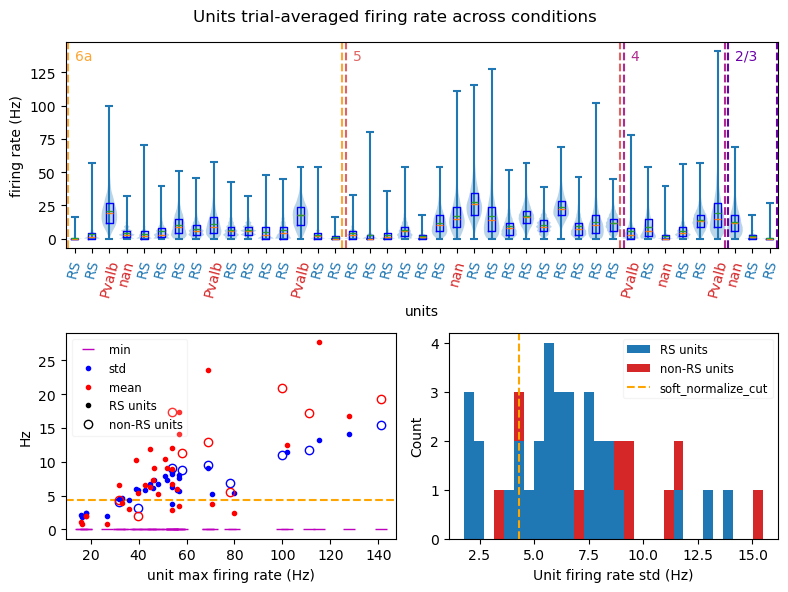

In [17]:
from toolkit.plots.colors import VISP_LAYER_COLORS_DICT

n_units = len(units_info)
unit_layer = units_info['layer_acronym'].values
layer_boundary_idx = np.nonzero(unit_layer[:-1] != unit_layer[1:])[0]
layer_boundary_idx = np.hstack([-1, layer_boundary_idx, unit_layer.size - 1])
is_RS = units_info['unit_type'].values == 'RS'
positions = np.arange(n_units)
boundary_gap = 0.1
firing_rate = units_fr.firing_rate.values.T  # (samples, units)

fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(2, 1, 1)
ax.violinplot(firing_rate, positions=positions, widths=.9)
ax.boxplot(firing_rate, positions=positions, widths=0.4, whis=(0, 100),
    showmeans=True, meanline=True, showfliers=False, showcaps=False,
    meanprops={'linestyle': '-'}, whiskerprops={'color':'none'}, boxprops={'color': 'blue'})
for i in layer_boundary_idx[:-1]:
    clr = VISP_LAYER_COLORS_DICT[unit_layer[i + 1]]
    ax.axvline(i + 0.5 + boundary_gap, linestyle='--', color=clr)
    ax.annotate(unit_layer[i + 1], xy=(i + 0.5 + boundary_gap, ax.get_ylim()[1]),
        xytext=(5, -5), textcoords='offset points', ha='left', va='top', color=clr)
for i in layer_boundary_idx[1:]:
    ax.axvline(i + 0.5 - boundary_gap, linestyle='--', color=VISP_LAYER_COLORS_DICT[unit_layer[i]])
ax.set_xticks(positions, labels=units_info['unit_type'], rotation=75)
for lb in ax.get_xticklabels():
    lb.set_color('tab:blue' if lb.get_text() == 'RS' else 'tab:red')
# ax.set_xticklabels()
ax.set_xlabel('units')
ax.set_ylabel('firing rate (Hz)')

ax = fig.add_subplot(2, 2, 3)
ax.axhline(soft_normalize_cut, linestyle='--', color='orange')
ax.plot(units_fr.units_fr_max, units_fr.units_fr_min, 'm.', marker='_', markersize=8, label='min')
ax.plot(units_fr.units_fr_max[is_RS], units_fr.units_fr_std[is_RS], 'b.', label='std')
ax.plot(units_fr.units_fr_max[~is_RS], units_fr.units_fr_std[~is_RS], 'bo', markerfacecolor='none')
ax.plot(units_fr.units_fr_max[is_RS], units_fr.units_fr_mean[is_RS], 'r.', label='mean')
ax.plot(units_fr.units_fr_max[~is_RS], units_fr.units_fr_mean[~is_RS], 'ro', markerfacecolor='none')
ax.plot([], [], 'k.', label='RS units')
ax.plot([], [], 'ko', markerfacecolor='none', label='non-RS units')
ax.set_xlabel('unit max firing rate (Hz)')
ax.set_ylabel('Hz')
ax.legend(loc='upper left', framealpha=0.2, fontsize='small')

ax = fig.add_subplot(2, 2, 4)
ax.hist([norm_scale[is_RS], norm_scale[~is_RS]], bins=30, stacked=True,
    color=['tab:blue', 'tab:red'], label=['RS units', 'non-RS units'])
ax.axvline(soft_normalize_cut, linestyle='--', color='orange', label='soft_normalize_cut')
ax.set_xlabel(f'Unit firing rate {normalization_scale:s} (Hz)')
ax.set_ylabel('Count')
ax.legend(loc='upper right', framealpha=0.2, fontsize='small')

fig.suptitle('Units trial-averaged firing rate across conditions')
fig.tight_layout()
plt.show()

In [33]:
sigma = 0.02  # seconds

units_smoothed_rate = {}
for stim in stimulus_names:
    units_smoothed_rate[stim] = smooth_spike_rate(
        units_spk_rate[stim], sigma,
        normalization_scale=norm_scale, soft_normalize_cut=soft_normalize_cut,
        time_dim='time_relative_to_stimulus_onset'
    )


In [19]:
from toolkit.utils.module import reload_module

# st = reload_module(st)
stack_xarray_dims = reload_module('toolkit.analysis.utils', 'stack_xarray_dims')
concat_stack_xarray_dims = reload_module('toolkit.analysis.utils', 'concat_stack_xarray_dims')